In [ ]:
import pandas as pd
from itertools import chain
import time
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, recall_score, \
                            precision_score, f1_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dataclasses import dataclass, field
import copy

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
class Timer: 
  '''For measuring performance'''
  def __enter__(self):
    self.start = time.perf_counter()
    return self
  def __exit__(self, exc_type, exc_value, exc_traceback):
    print(f'{(time.perf_counter() - self.start):.2f} seconds')

In [ ]:
NUM_LANDMARKS = 21
NUM_FRAMES_PER_GESTURE = 32
GESTURES_NAMES = ['WAWING', 'SCISSORS', 'FLIP', 'PUSH&PULL', 'OPEN&CLOSE'] 

# Data loading

In [ ]:
# Path to the files
path = '/content/drive/My Drive/Colab Notebooks/Hand Gestures DB/'

data_train = pd.read_csv(path + 'X.txt', header=None)
data_train.columns = list(chain.from_iterable((f'X_{i}', f'Y_{i}') for i in range(NUM_LANDMARKS)))
labels_train = pd.read_csv(path + 'Y.txt', header=None)
labels_train.columns = ['Labels']

data_test = pd.read_csv(path + 'X_test.txt', header=None)
data_test.columns = list(chain.from_iterable((f'X_{i}', f'Y_{i}') for i in range(NUM_LANDMARKS)))
labels_test = pd.read_csv(path + 'Y_test.txt', header=None)
labels_test.columns = ['Labels']

data_train

,X_0,Y_0,X_1,Y_1,X_2,Y_2,X_3,Y_3,X_4,Y_4,...,X_16,Y_16,X_17,Y_17,X_18,Y_18,X_19,Y_19,X_20,Y_20
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.338042,0.684645,0.297611,0.627241,0.286333,0.556801,0.294406,0.497184,0.302227,0.456359,...,0.411883,0.365619,0.404607,0.617020,0.441776,0.558930,0.462125,0.523720,0.478410,0.489527
4,0.314534,0.708633,0.279920,0.642538,0.280690,0.563946,0.306041,0.501234,0.331042,0.467960,...,0.417144,0.375339,0.394682,0.637237,0.442601,0.561688,0.466805,0.526900,0.485263,0.496765
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115387,0.629738,0.406995,0.661314,0.370314,0.685644,0.317929,0.703761,0.270595,0.718342,0.230797,...,0.572310,0.114610,0.567878,0.292783,0.539226,0.256594,0.520203,0.230908,0.503434,0.204637
115388,0.626519,0.405399,0.658629,0.366865,0.683048,0.313918,0.701826,0.266782,0.716086,0.227622,...,0.569263,0.115545,0.564501,0.291754,0.536143,0.256425,0.517421,0.231005,0.501044,0.205380
115389,0.624711,0.403654,0.657308,0.364137,0.682465,0.310022,0.701882,0.262560,0.716896,0.222087,...,0.567443,0.115705,0.562898,0.291827,0.536559,0.256385,0.518573,0.231014,0.502567,0.205059
115390,0.628123,0.397418,0.654637,0.349472,0.672734,0.285973,0.690058,0.237222,0.704243,0.197686,...,0.562685,0.124668,0.572967,0.300797,0.550993,0.266042,0.533908,0.241411,0.517347,0.217583


In [ ]:
# The labels are enumerated starting from 0
labels_train = labels_train - 1
labels_test = labels_test - 1

In [ ]:
def chunks(lst: list, n: int):
    '''Yield successive n-sized chunks from lst.'''
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

In [ ]:
data_train = data_train.values.tolist()
data_test = data_test.values.tolist()
labels_train = labels_train.values.tolist()
labels_test = labels_test.values.tolist()

In [ ]:
data_train = [i for i in chunks(data_train, NUM_FRAMES_PER_GESTURE)]
data_test = [i for i in chunks(data_test, NUM_FRAMES_PER_GESTURE)]

In [ ]:
print(len(data_train))
print(len(data_test))

3606
362


In [ ]:
# Get more samples for testing
data_train, data_test_2, labels_train, labels_test_2 = train_test_split(data_train, labels_train, test_size=0.12, random_state=42, stratify=labels_train)

In [ ]:
data_test += data_test_2
labels_test += labels_test_2

In [ ]:
print(len(data_train))
print(len(data_test))

3173
795


# Data preprocessing

In [ ]:
def invert_x_coordinate(data: list) -> list:
  '''Invert the X coordinate, making a mirror effect'''
  data_inverted_x = copy.deepcopy(data)
  for i in range(len(data)):
    for j in range(len(data[0])):
      for k in range(0,len(data[0][0]),2):
        if data_inverted_x[i][j][k]:
          data_inverted_x[i][j][k] = 1 - data_inverted_x[i][j][k]
  return data_inverted_x

In [ ]:
def invert_frames_in_time(data: list) -> list:
  '''Invert the frame coordinates order in time'''
  return [gesture[::-1] for gesture in data]

In [ ]:
def augment_data(data: list, labels: list) -> None:
  '''Augments the data using all the predefined tricks'''
  data += invert_x_coordinate(data)
  labels += labels
  data += invert_frames_in_time(data)
  labels += labels

In [ ]:
def remove_defective_gestures(data: list, labels: list, threshold = 6):
  '''Remove those gestures that have many coordinates equal to 0'''
  deleted_gestures = 0
  for i in range(len(data)):
    failures_count = 0
    for frames in data[i - deleted_gestures]:
      if all(coordinates == 0 for coordinates in frames):
        failures_count += 1
    if failures_count >= threshold:
      data.pop(i - deleted_gestures)
      labels.pop(i - deleted_gestures)
      deleted_gestures += 1

remove_defective_gestures(data_train, labels_train)
remove_defective_gestures(data_test, labels_test)

# Model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
num_filters_conv = 32
hidden_lstm = 16


class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv = nn.Conv1d(in_channels=NUM_LANDMARKS * 2, out_channels=num_filters_conv, kernel_size=3)
    self.lstm = nn.LSTM(input_size=num_filters_conv,
                              hidden_size=hidden_lstm,
                              batch_first=True,
                              bidirectional=True)
    self.dropout = nn.Dropout(0.4)
    self.lin = nn.Linear(hidden_lstm * 2, len(GESTURES_NAMES))
    self.softmax = nn.LogSoftmax(dim = 1)

  def forward(self, x):
    x = F.relu(self.dropout(self.conv(x)))
    x = x.view(-1, NUM_FRAMES_PER_GESTURE - 2, num_filters_conv)
    x, (hn, cn) = self.lstm(x)
    x = hn.transpose(0,1).reshape(-1,2 * hidden_lstm)
    x = self.lin(self.dropout(x))
    x = self.softmax(x)
    return x


print(Net())

Net(
  (conv): Conv1d(42, 32, kernel_size=(3,), stride=(1,))
  (lstm): LSTM(32, 16, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (lin): Linear(in_features=32, out_features=5, bias=True)
  (softmax): LogSoftmax(dim=1)
)


In [ ]:
@dataclass
class Metrics:
  '''Stores several metric values'''
  loss: float
  true_value: np.ndarray
  predicted: np.ndarray

  precision: float = field(init=False)
  accuracy: float = field(init=False)
  f1: float = field(init=False)
  recall: float = field(init=False)

  def __post_init__(self):
    self.precision = precision_score(self.true_value, 
                                     self.predicted, average='weighted', 
                                     zero_division=1)
    self.accuracy = accuracy_score(self.true_value, self.predicted)
    self.f1 = f1_score(self.true_value, self.predicted, 
                       average='weighted', 
                       zero_division=1)
    self.recall = recall_score(self.true_value,
                               self.predicted, average='weighted', 
                               zero_division=1)

  def __repr__(self):
    return f'Loss: {self.loss:.4f}, Accuracy: {self.accuracy:.3f}, Precision: {self.precision:.3f}, Recall: {self.recall:.3f}, F1 score: {self.f1:.3f}'


In [ ]:
def train(network: nn.Module, loader: torch.utils.data.DataLoader) -> Metrics:
  network.train()
  predicted = np.array([])
  true_value = np.array([])
  for data, target in loader:
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target.view(-1).long())
    loss.backward()
    optimizer.step()
        
    predicted = np.append(predicted, output.data.max(1)[1].numpy())
    true_value = np.append(true_value, target.squeeze().numpy())
  return Metrics(loss.item(), true_value, predicted)  


def test(network: nn.Module, loader: torch.utils.data.DataLoader) -> Metrics:
  network.eval()
  with torch.no_grad():
    for data, target in loader:
      output = network(data)
      loss = F.nll_loss(output, target.view(-1).long())
      predicted = output.data.max(1)[1].numpy()
      true_value = target.squeeze().numpy()
  return Metrics(loss.item(), true_value, predicted)

In [ ]:
def create_tensor_list(data: list, labels: list) -> list:
  '''Returns a tensor list which contains all the data and labells'''
  return [(torch.Tensor(v).transpose(0,1), torch.IntTensor(labels[i])) for (i, v) in enumerate(data)]

# Cross validation

In [ ]:
num_epochs = 200
batch_size = 640
learning_rate = 0.001

In [ ]:
k_folds = 4

results = []

torch.manual_seed(42)
kfold = KFold(n_splits=k_folds, shuffle=True)

for fold_number, (train_ids, test_ids) in enumerate(kfold.split(data_train)):
  net = Net()
  optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
  

  data_train_batch = [data_train[i] for i in train_ids]
  labels_train_batch = [labels_train[i] for i in train_ids]
  augment_data(data_train_batch, labels_train_batch)

  data_val_batch = [data_train[i] for i in test_ids]
  labels_val_batch = [labels_train[i] for i in test_ids]
  augment_data(data_val_batch, labels_val_batch)

  train_loader = torch.utils.data.DataLoader(create_tensor_list(data_train_batch, labels_train_batch),
                                               batch_size=batch_size, shuffle=True)
  validation_loader = torch.utils.data.DataLoader(create_tensor_list(data_val_batch, labels_val_batch),
                                                    batch_size=len(data_val_batch))
  
  print(f'Fold {fold_number + 1}:')
  with Timer():
    for epoch in range(num_epochs):
      print(f'Epoch {epoch + 1}:')
      train_result = train(net, train_loader)
      validation_result = test(net, validation_loader)
      print(f'Train {train_result}')
      print(f'Val {validation_result}')
      print('-'*90)

  results.append({'train': train_result, 'validation': validation_result})

Fold 1:
Epoch 1:
Train Loss: 1.6135, Accuracy: 0.213, Precision: 0.208, Recall: 0.213, F1 score: 0.179
Val Loss: 1.6097, Accuracy: 0.250, Precision: 0.710, Recall: 0.250, F1 score: 0.141
------------------------------------------------------------------------------------------
Epoch 2:
Train Loss: 1.6005, Accuracy: 0.229, Precision: 0.216, Recall: 0.229, F1 score: 0.182
Val Loss: 1.6036, Accuracy: 0.218, Precision: 0.704, Recall: 0.218, F1 score: 0.112
------------------------------------------------------------------------------------------
Epoch 3:
Train Loss: 1.5829, Accuracy: 0.251, Precision: 0.269, Recall: 0.251, F1 score: 0.183
Val Loss: 1.5902, Accuracy: 0.260, Precision: 0.711, Recall: 0.260, F1 score: 0.144
------------------------------------------------------------------------------------------
Epoch 4:
Train Loss: 1.5554, Accuracy: 0.285, Precision: 0.325, Recall: 0.285, F1 score: 0.222
Val Loss: 1.5670, Accuracy: 0.237, Precision: 0.702, Recall: 0.237, F1 score: 0.127
---

In [ ]:
results

[{'train': Loss: 0.1255, Accuracy: 0.950, Precision: 0.950, Recall: 0.950, F1 score: 0.950,
  'validation': Loss: 0.1019, Accuracy: 0.978, Precision: 0.979, Recall: 0.978, F1 score: 0.978},
 {'train': Loss: 0.1171, Accuracy: 0.947, Precision: 0.948, Recall: 0.947, F1 score: 0.947,
  'validation': Loss: 0.0634, Accuracy: 0.985, Precision: 0.985, Recall: 0.985, F1 score: 0.985},
 {'train': Loss: 0.2024, Accuracy: 0.979, Precision: 0.979, Recall: 0.979, F1 score: 0.979,
  'validation': Loss: 0.1114, Accuracy: 0.958, Precision: 0.965, Recall: 0.958, F1 score: 0.958},
 {'train': Loss: 0.0948, Accuracy: 0.972, Precision: 0.972, Recall: 0.972, F1 score: 0.972,
  'validation': Loss: 0.0589, Accuracy: 0.983, Precision: 0.983, Recall: 0.983, F1 score: 0.983}]

# Model training

In [ ]:
net = Net()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

augment_data(data_train, labels_train)
train_loader = torch.utils.data.DataLoader(create_tensor_list(data_train, labels_train),
                                           batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs):
  print(f'Epoch {epoch + 1}:')
  train_result = train(net, train_loader)
  print(f'Train {train_result}')
  print('-'*90)
  
augment_data(data_test, labels_test)
test_loader = torch.utils.data.DataLoader(create_tensor_list(data_test, labels_test),
                                           batch_size=len(data_test))
test_result = test(net, test_loader)

Epoch 1:
Train Loss: 1.6108, Accuracy: 0.211, Precision: 0.224, Recall: 0.211, F1 score: 0.164
------------------------------------------------------------------------------------------
Epoch 2:
Train Loss: 1.5942, Accuracy: 0.241, Precision: 0.253, Recall: 0.241, F1 score: 0.216
------------------------------------------------------------------------------------------
Epoch 3:
Train Loss: 1.5629, Accuracy: 0.275, Precision: 0.284, Recall: 0.275, F1 score: 0.258
------------------------------------------------------------------------------------------
Epoch 4:
Train Loss: 1.4056, Accuracy: 0.321, Precision: 0.317, Recall: 0.321, F1 score: 0.311
------------------------------------------------------------------------------------------
Epoch 5:
Train Loss: 1.1927, Accuracy: 0.427, Precision: 0.432, Recall: 0.427, F1 score: 0.407
------------------------------------------------------------------------------------------
Epoch 6:
Train Loss: 1.0739, Accuracy: 0.480, Precision: 0.499, Recall

In [ ]:
test_result

Loss: 0.0430, Accuracy: 0.985, Precision: 0.985, Recall: 0.985, F1 score: 0.985

# Confusion matrix

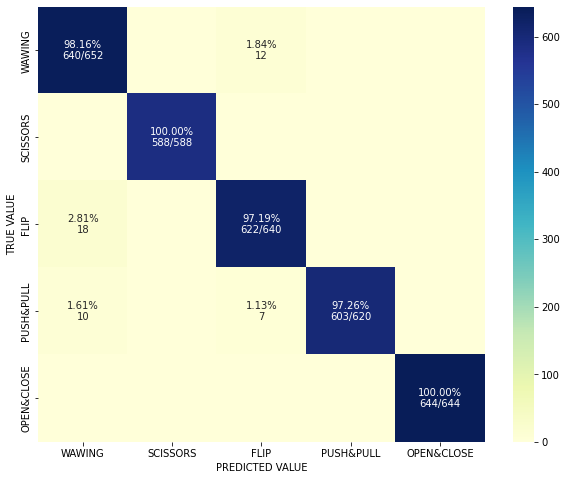

In [ ]:
cm = confusion_matrix(test_result.true_value, test_result.predicted)
cm_sum = np.sum(cm, axis=1, keepdims=True)
cm_perc = cm / cm_sum.astype(float) * 100
annot = np.empty_like(cm).astype(str)
nrows, ncols = cm.shape
for i in range(nrows):
  for j in range(ncols):
    c = cm[i, j]
    p = cm_perc[i, j]
    if i == j:
      s = cm_sum[i]
      annot[i, j] = '%.2f%%\n%d/%d' % (p, c, s)
    elif c == 0:
      annot[i, j] = ''
    else:
      annot[i, j] = '%.2f%%\n%d' % (p, c)
cm = pd.DataFrame(cm, index=GESTURES_NAMES, columns=GESTURES_NAMES)
cm.index.name = 'TRUE VALUE'
cm.columns.name = 'PREDICTED VALUE'
plt.subplots(figsize=(10, 8))
sns.heatmap(cm, annot=annot, fmt='', cmap="YlGnBu")
plt.show()

# Save the model

In [ ]:
data, _ = next(iter(train_loader))
# Run the tracing
net.eval()
traced_net = torch.jit.trace(net, data[0].float())
# Save the converted model
traced_net.save(path + '/hand_gestures_classifier.pt')

In [ ]:
for name, param in traced_net.named_parameters():
  if param.requires_grad:
    print(f'Layer: {name}, Shape:{param.detach().numpy().shape}')

Layer: conv.weight, Shape:(32, 42, 3)
Layer: conv.bias, Shape:(32,)
Layer: lstm.weight_ih_l0, Shape:(64, 32)
Layer: lstm.weight_hh_l0, Shape:(64, 16)
Layer: lstm.bias_ih_l0, Shape:(64,)
Layer: lstm.bias_hh_l0, Shape:(64,)
Layer: lstm.weight_ih_l0_reverse, Shape:(64, 32)
Layer: lstm.weight_hh_l0_reverse, Shape:(64, 16)
Layer: lstm.bias_ih_l0_reverse, Shape:(64,)
Layer: lstm.bias_hh_l0_reverse, Shape:(64,)
Layer: lin.weight, Shape:(5, 32)
Layer: lin.bias, Shape:(5,)
